Analyze SBI-SGM, new bounds, new SGM, only three parameters needed

parameters order is  :tauG,speed,alpha (In second)

## Import some pkgs

In [1]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict

In [2]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch

## Some fns

In [4]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from utils.measures import geodesic_dist, reg_R_fn, lin_R_fn

def divideFc(fc):
    """Divide the FC into three blocks and vector them
    """
    size_fc = len(fc)
    hs_fc = int(size_fc/2)
    fc_block1 = fc[:hs_fc, :hs_fc]
    fc_block2 = fc[hs_fc:, hs_fc:];
    fc_block3 = fc[:hs_fc, hs_fc:];
    vec1 = _minmax_vec(fc_block1[np.triu_indices(hs_fc, k = 1)])
    vec2 = _minmax_vec(fc_block2[np.triu_indices(hs_fc, k = 1)])
    vec3 = _minmax_vec(fc_block3.flatten())
    return vec1, vec2, vec3

def cal_metrics(fc1, fc2):
    """Calculate the distance between fc1 and fc2, including
        1. geodesic dist
        2. pearson's R
        3. lin R
        4. pearson's R after divide the FC into three blocks
        5. lin R after divide the FC into three blocks
    """
    fc1 = fc1.astype(np.float64)
    fc2 = fc2.astype(np.float64)
    size_fc = len(fc1)
    
    # for geodedic
    fc1_g = fc1/np.linalg.norm(fc1) + np.eye(size_fc)
    fc2_g = fc2/np.linalg.norm(fc2) + np.eye(size_fc)
    
    fc1_c = _minmax_vec(fc1[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    fc2_c = _minmax_vec(fc2[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    
    # all metrics
    geo_dist = geodesic_dist(fc1_g, fc2_g)
    reg_r = reg_R_fn(fc1_c, fc2_c)
    lin_r = lin_R_fn(fc1_c, fc2_c)
    mse = np.mean((fc1_c-fc2_c)**2)
    tau_r = kendalltau(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    sp_r = spearmanr(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    
    # block wise metrics
    blocks1 = divideFc(fc1)
    blocks2 = divideFc(fc2)
    reg_r_block = [reg_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    lin_r_block = [lin_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    
    res = edict()
    res.geo_dist = geo_dist
    res.reg_r = reg_r[0]
    res.lin_r = lin_r[0]
    res.tau_r = tau_r
    res.sp_r = sp_r 
    res.mse = mse
    res.reg_r_block = np.mean(reg_r_block)
    res.lin_r_block = np.mean(lin_r_block)
    return res

def cal_metrics_batch(fc1s, fc2s):
    """fc1s, fc2s: num_fc x 68 x 68
    """
    ress = ddict(list)
    for ix in range(len(fc1s)):
        fc_t = fc2s[ix]
        fc_e = fc1s[ix]
        res = cal_metrics(fc_t, fc_e)
        for key, v in res.items():
            ress[key].append(v)
    
    return ress

In [28]:
def _simulate_data(raw_params, brain, prior_bds, freqranges, diag_ws):
    params = []
    for raw_param, prior_bd in zip(raw_params, prior_bds):
        param =  _map_fn_torch(raw_param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params.append(param)
    params = torch.tensor(params)
    
    params_dict = dict()
    params_dict["tauC"] =  params[0].item()
    params_dict["speed"] =  params[1].item()
    params_dict["alpha"] =  params[2].item()
    ress = []
    for freqrange in freqranges:
        modelFC = build_fc_freq_m(brain, params_dict, freqrange, diag_ws)
        modelFC_abs = np.abs(modelFC[:68, :68])
        ress.append(modelFC_abs)
    return np.array(ress)

In [6]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

<function __main__.<lambda>(x)>

In [24]:
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

### Some parameters

In [7]:
from scipy.io import loadmat
diag_ws = np.ones(82)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
# Parameter bounds for optimization
v_lower = 3.5-1.8
v_upper = 3.5+1.8
#bnds = ((0.005,0.030), (0.005,0.2), (0.005,0.030), (v_lower,v_upper), (0.1,1.0), (0.5,10.0), (0.5,10.0));
bnds = ((0.005,0.030), (v_lower,v_upper), (0.1,1.0));
#taue,taui,tauG,speed,alpha,gii,gei

In [9]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta_l = [13, 20]


In [10]:
paras = edict()

paras.bands = ["delta", "theta", "alpha", "beta_l"]
paras.freqranges =  [np.linspace(_paras[band][0], _paras[band][1], 5) 
                     for band in paras.bands]
paras.diag_ws = diag_ws
print(paras.freqranges)
paras.fs = 600
paras.num_nodes = 86 # Number of cortical (68) + subcortical nodes
#paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
#paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
paras.par_low = np.asarray([0.005, 5, 0.1])
paras.par_high = np.asarray([0.03, 20, 1])
paras.names = ["TauC", "Speed", "alpha"]
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.prior_sd = 10
paras.add_v = 0.01

paras.SBI_paras = edict()
paras.SBI_paras.num_prior_sps = int(1e4)
paras.SBI_paras.density_model = "nsf"
paras.SBI_paras.num_round = 2
paras.SBI_paras.noise_sd = 0.20
paras.SBI_paras.save_dir =  f"rawfc_posteriorMRmulDiffNum_{'-'.join(paras.bands)}_" + \
                            f"num{paras.SBI_paras.num_prior_sps}_" + \
                            f"density{paras.SBI_paras.density_model}_" + \
                            f"MR{paras.SBI_paras.num_round}_" + \
                            f"noise_sd{paras.SBI_paras.noise_sd*100:.0f}_" +\
                            f"addv{paras.add_v*100:.0f}"
print(paras.SBI_paras.save_dir)
assert (RES_ROOT/paras.SBI_paras.save_dir).exists()
paras.diag_ws

[array([2.   , 2.375, 2.75 , 3.125, 3.5  ]), array([4.  , 4.75, 5.5 , 6.25, 7.  ]), array([ 8.,  9., 10., 11., 12.]), array([13.  , 14.75, 16.5 , 18.25, 20.  ])]
rawfc_posteriorMRmulDiffNum_delta-theta-alpha-beta_l_num10000_densitynsf_MR2_noise_sd20_addv1


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [11]:
# fn for reparemetering
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

functools.partial(<function theta_raw_2out at 0x7f825496f430>, map_fn=functools.partial(<function logistic_np at 0x7f825496f3a0>, k=0.1))

In [12]:
prior = MultivariateNormal(loc=torch.zeros(3), covariance_matrix=torch.eye(3)*(paras.prior_sd**2))

MultivariateNormal(loc: torch.Size([3]), covariance_matrix: torch.Size([3, 3]))

### Load the data

In [13]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

# PSD
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
fvec = ind_psd_xr["frequencies"].values;

In [14]:

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.quantile(cur_ind_conn, 0.99)*paras.add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn


if paras.add_v != 0:
    print(f"Add {paras.add_v} on diag")
    ind_conn_adds = [_add_v2con(ind_conn[:, :, ix]) for ix in range(36)]
    ind_conn = np.transpose(np.array(ind_conn_adds), (1, 2, 0))

Add 0.01 on diag


In [15]:
# em FC
fc_root = RES_ROOT/"emp_fcs"
fcss = []
for band in paras.bands:
    def _get_fc(sub_ix, bd):
        fil = list(fc_root.rglob(f"*{bd}*/sub{sub_ix}.pkl"))[0]
        return load_pkl(fil, verbose=False)
    
    fcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    fcss.append(fcs)

## Analyze the results for single data

In [16]:
res_fils = list((RES_ROOT/paras.SBI_paras.save_dir).glob("ind*.pkl"))
_sorted_fn = lambda x: int(x.stem.split("ind")[-1][:])
sorted_fils = sorted(res_fils, key=_sorted_fn);

### Point est

In [17]:
cur_idx = 0
cur_posterior = load_pkl(sorted_fils[cur_idx])
post_sps = cur_posterior.sample((10000, ));

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc_posteriorMRmulDiffNum_delta-theta-alpha-beta_l_num10000_densitynsf_MR2_noise_sd20_addv1/ind0.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/home/hujin/.local/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


In [19]:
len(fcss)

4

In [22]:
cur_est_paras = torch.median(post_sps, axis=0)[0]
    
# get the cur brain
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.connectome =  ind_conn[:, :, cur_idx] # re-assign connectome to individual connectome
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
    
cur_obs_FCs = [np.abs(fcs[cur_idx]) for fcs in fcss]
cur_est_FCs = _simulate_data(cur_est_paras, 
                               brain=brain, 
                               prior_bds=paras.prior_bds, 
                               freqranges=paras.freqranges, 
                               diag_ws=paras.diag_ws);
for cur_est_FC, cur_obs_FC in zip(cur_est_FCs, cur_obs_FCs):
    est_vec = _minmax_vec(cur_est_FC[np.triu_indices(68, k = 1)])
    obs_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
    corr = scipy.stats.pearsonr(est_vec, obs_vec)[0]
    print(corr)

0.36507412345254275
0.43464294053809316
0.41993915985578856
0.27001151084943004


<AxesSubplot:title={'center':'SC'}>

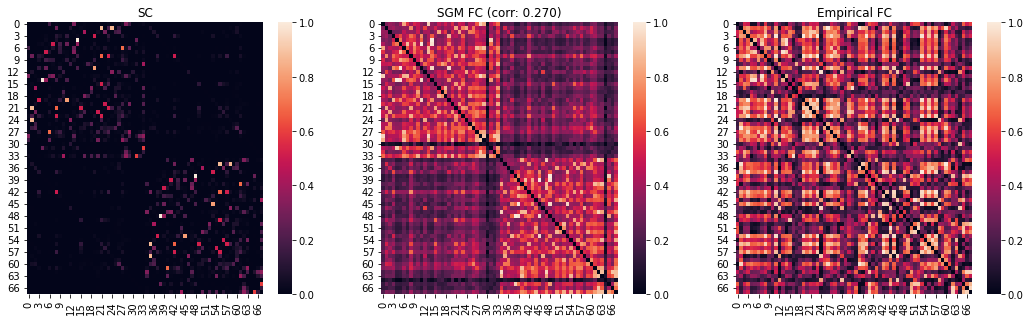

In [25]:
SC = brain.connectome[:68, :68]
SC_vec = _minmax_vec(SC[np.triu_indices(68, k = 1)])
est_FC_mm = _vec_2mat(_minmax_vec(cur_est_FCs[0][np.triu_indices(68, k = 1)]))
obs_FC_mm = _vec_2mat(_minmax_vec(cur_obs_FCs[0][np.triu_indices(68, k = 1)]))
SC_mm = _vec_2mat(SC_vec)

plt.figure(figsize=[18, 5])
plt.subplot(132)
plt.title(f"SGM FC (corr: {corr:.3f})")
sns.heatmap(est_FC_mm)
plt.subplot(133)
plt.title("Empirical FC")
sns.heatmap(obs_FC_mm)
#sns.heatmap(cur_obs_FC)
plt.subplot(131)
plt.title("SC")
sns.heatmap(SC_mm)

### Full Bayesian

In [40]:
cur_idx = 0
# get the cur brain
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.connectome =  ind_conn[:, :, cur_idx] # re-assign connectome to individual connectome
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

_simulate_data_sp = partial(_simulate_data, 
                            brain=brain, 
                            prior_bds=paras.prior_bds, 
                            freqranges=paras.freqranges, 
                            diag_ws=paras.diag_ws)
_simulate_data_wrapper, _ = prepare_for_sbi(_simulate_data_sp, prior)

In [41]:
cur_posterior = load_pkl(sorted_fils[cur_idx])

_, cur_post_psds = simulate_for_sbi(_simulate_data_wrapper, cur_posterior,
                                    num_simulations=100, 
                                    num_workers=20)
cur_post_psds = cur_post_psds.reshape(-1, 4, 68, 68);

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc_posteriorMRmulDiffNum_delta-theta-alpha-beta_l_num10000_densitynsf_MR2_noise_sd20_addv1/ind0.pkl


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

In [47]:
band_idx = 0
cur_obs_FC = np.abs(fcss[band_idx][cur_idx])
cur_est_FC = np.abs(cur_post_psds[:, band_idx].mean(axis=0).numpy())
est_vec = _minmax_vec(cur_est_FC[np.triu_indices(68, k = 1)])
obs_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
corr = scipy.stats.pearsonr(est_vec, obs_vec)[0]

0.36658139277566154

<AxesSubplot:title={'center':'SC'}>

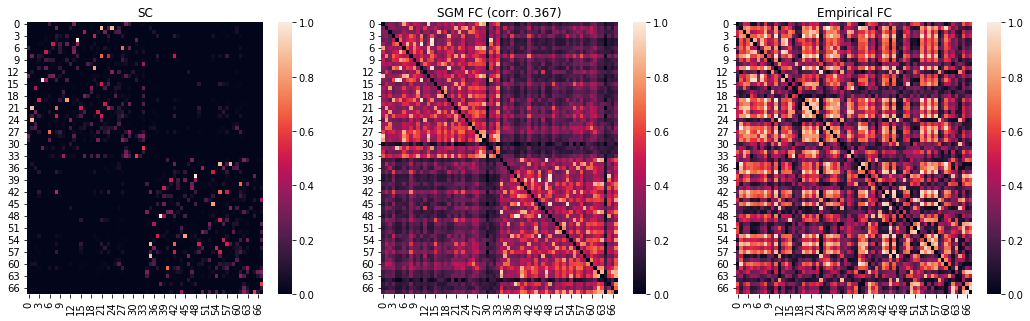

In [48]:
# no diag ws, only three sgm parameters
SC = brain.connectome[:68, :68]
SC_vec = _minmax_vec(SC[np.triu_indices(68, k = 1)])
est_FC_mm = _vec_2mat(est_vec)
obs_FC_mm = _vec_2mat(obs_vec)
SC_mm = _vec_2mat(SC_vec)

plt.figure(figsize=[18, 5])
plt.subplot(132)
plt.title(f"SGM FC (corr: {corr:.3f})")
sns.heatmap(est_FC_mm)
plt.subplot(133)
plt.title("Empirical FC")
sns.heatmap(obs_FC_mm)
#sns.heatmap(cur_obs_FC)
plt.subplot(131)
plt.title("SC")
sns.heatmap(SC_mm)

## All data analysis

In [49]:
res_fils = list((RES_ROOT/paras.SBI_paras.save_dir).glob("ind*.pkl"))
_sorted_fn = lambda x: int(x.stem.split("ind")[-1][:])
sorted_fils = sorted(res_fils, key=_sorted_fn);

### Point est

In [52]:
inf_res = edict()
for band in paras.bands:
    inf_res[f"est_FCs_{band}"] = []
    inf_res[f"metrics_{band}"] = []

for sub_idx in range(36):
    cur_posterior = load_pkl(sorted_fils[sub_idx], False)
    post_sps = cur_posterior.sample((1000, ))
    print(post_sps.shape)
    cur_est_paras = torch.median(post_sps, axis=0)[0]
        
    # get the cur brain
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  ind_conn[:, :, sub_idx] # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
        
    cur_est_FCs = _simulate_data(cur_est_paras, 
                                   brain=brain, 
                                   prior_bds=paras.prior_bds, 
                                   freqranges=paras.freqranges, 
                                   diag_ws=paras.diag_ws
                                  )
    for band_idx in range(4):
        cur_obs_FC = np.abs(fcss[band_idx][sub_idx])
        cur_est_FC = np.abs(cur_est_FCs[band_idx])
        inf_res[f"est_FCs_{paras.bands[band_idx]}"].append(cur_est_FC)
        inf_res[f"metrics_{paras.bands[band_idx]}"].append(cal_metrics(cur_obs_FC, cur_est_FC))
save_pkl(sorted_fils[0].parent/f"inf_res.pkl", inf_res, False)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3])
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc_posteriorMRmulDiffNum_delta-theta-alpha-beta_l_num10000_densitynsf_MR2_noise_sd20_addv1/inf_res_beta_l.pkl


In [57]:
metrics_df = pd.DataFrame(inf_res.metrics_theta)
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.624589,0.241610,0.188079,0.115768,0.171272,0.081729,0.215096,0.177811
std,0.031586,0.153047,0.128909,0.074254,0.108272,0.032346,0.143861,0.123155
min,0.549449,0.028994,0.018887,0.015316,0.022621,0.040514,0.018181,0.016840
25%,0.600332,0.090241,0.073810,0.054995,0.082771,0.060243,0.081541,0.067100
50%,0.628654,0.221018,0.163341,0.099727,0.147998,0.070339,0.192487,0.148113
75%,0.647317,0.389172,0.288569,0.163302,0.241092,0.098902,0.352486,0.301739
max,0.692983,0.484726,0.411104,0.314122,0.457029,0.170891,0.455169,0.399944


### Full Bayesian

In [58]:
inf_res_fb = edict()
for band in paras.bands:
    inf_res_fb[f"est_FCs_{band}"] = []
    inf_res_fb[f"metrics_{band}"] = []

metrics = []
for sub_idx in range(36):
# get the cur brain
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  ind_conn[:, :, sub_idx] # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    
    _simulate_data_sp = partial(_simulate_data, 
                                brain=brain, 
                                prior_bds=paras.prior_bds, 
                                freqranges=paras.freqranges,
                                diag_ws=paras.diag_ws)
    _simulate_data_wrapper, _ = prepare_for_sbi(_simulate_data_sp, prior)
    
    cur_posterior = load_pkl(sorted_fils[sub_idx], False)
    _, cur_post_fcs = simulate_for_sbi(_simulate_data_wrapper, cur_posterior,
                                        num_simulations=1000, 
                                        num_workers=50)
    cur_post_fcs = cur_post_fcs.reshape(-1, 4, 68, 68)
    print(cur_post_fcs.shape)
    
    for band_idx in range(4):
        cur_obs_FC = np.abs(fcss[band_idx][sub_idx])
        cur_est_FC = np.abs(cur_post_fcs.mean(axis=0).numpy())[band_idx]
        inf_res_fb[f"est_FCs_{paras.bands[band_idx]}"].append(cur_est_FC)
        inf_res_fb[f"metrics_{paras.bands[band_idx]}"].append(cal_metrics(cur_obs_FC, cur_est_FC))
    
save_pkl(sorted_fils[0].parent/"inf_res_fb.pkl", inf_res_fb)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 4, 68, 68])
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/rawfc_posteriorMRmulDiffNum_delta-theta-alpha-beta_l_num10000_densitynsf_MR2_noise_sd20_addv1/inf_res_fb.pkl


In [60]:
metrics_df = pd.DataFrame(inf_res_fb.metrics_theta);
metrics_df.describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.612370,0.249573,0.193035,0.118527,0.175557,0.080814,0.220877,0.182398
std,0.028644,0.143071,0.120793,0.067956,0.099047,0.032183,0.133814,0.115576
min,0.556917,0.029420,0.019079,0.017633,0.026866,0.040106,0.018403,0.017007
25%,0.587506,0.116712,0.085821,0.065172,0.098355,0.059718,0.101973,0.080183
50%,0.613386,0.222736,0.169350,0.096166,0.143408,0.070477,0.191669,0.147038
75%,0.631543,0.387431,0.293068,0.164393,0.242173,0.095358,0.352320,0.304438
max,0.685076,0.478181,0.390522,0.303615,0.441765,0.168783,0.450564,0.396204
